In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import io
import os
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, fcluster
from scipy.spatial.distance import pdist
from bioinfokit.visuz import cluster

############################################
############### Parsing dati ###############

#Lettura dati da dataset
path_random = str(pathlib.Path().absolute()) + "/output/random/"
path_small = str(pathlib.Path().absolute()) + "/output/small/"
path_big = str(pathlib.Path().absolute()) + "/output/big/"

# big

In [2]:
df_big = pd.DataFrame(columns=['dim', 'resp_time', 'throughput'])

for root, dirs, files in os.walk(path_big):
    for file in files:
        if file.endswith("0.csv"):
            dim=int(file.strip(".csv"))
            df = pd.read_csv(os.path.join(root, file))
            tp = df[df.responseMessage == 'OK'].shape[0]/60
            resp_time = df.elapsed
            resp_time.replace(0, np.nan, inplace=True)
            resp_time = resp_time.mean(skipna=True)
            row=[int(dim), resp_time, tp]
            df_big.loc[len(df_big)] = row

df_big.sort_values(by='dim',inplace=True, ignore_index=True)

df_big

,dim,resp_time,throughput
0,2500.0,15.026493,42.150000
1,2500.0,14.004350,42.150000
2,2500.0,12.907793,40.850000
3,2500.0,14.610123,42.150000
4,2500.0,13.807829,42.150000
5,5000.0,11.061257,83.800000
6,5000.0,10.728918,83.800000
7,5000.0,10.528441,83.800000
8,5000.0,14.238218,83.816667
9,5000.0,10.844502,83.816667


Nel caso in cui la deviazione standard è troppo elevata buona metrica la mediana, ma vedi anche il fattore COV, rapporto tra deviazione standard e media, se >0.5 media non è un buon indicatore

In [3]:
dim = []
tr = []
resp = []

for k,i in df_big.groupby('dim'):
    t_std = df_big.groupby('dim').get_group(k)['throughput'].std()
    r_std = df_big.groupby('dim').get_group(k)['resp_time'].std()
    t_mean = df_big.groupby('dim').get_group(k)['throughput'].mean()
    r_mean = df_big.groupby('dim').get_group(k)['resp_time'].mean()
    t_med = df_big.groupby('dim').get_group(k)['throughput'].median()
    r_med = df_big.groupby('dim').get_group(k)['resp_time'].median()
    
    t_cov = t_std/t_mean
    r_cov = r_std/r_mean
    dim.append(k)
    if t_cov < 0.5:
        tr.append(t_mean)
    else:
        tr.append(t_med)
    if r_cov < 0.5:
        resp.append(r_mean)
    else:
        resp.append(r_med)
    
df_big_mean = pd.DataFrame({'dim':dim, 'throughput':tr, 'resp_time':resp})
df_big_mean

,dim,throughput,resp_time
0,2500.0,41.890000,14.071317
1,5000.0,83.806667,11.480267
2,7500.0,125.426667,9.858139
3,10000.0,166.620000,9.566922
4,15000.0,247.650000,16.289633
5,20000.0,285.823333,62.069524
6,25000.0,273.503333,77.680508
7,30000.0,270.323333,81.361707
8,35000.0,270.716667,82.299385
9,40000.0,267.950000,84.358821


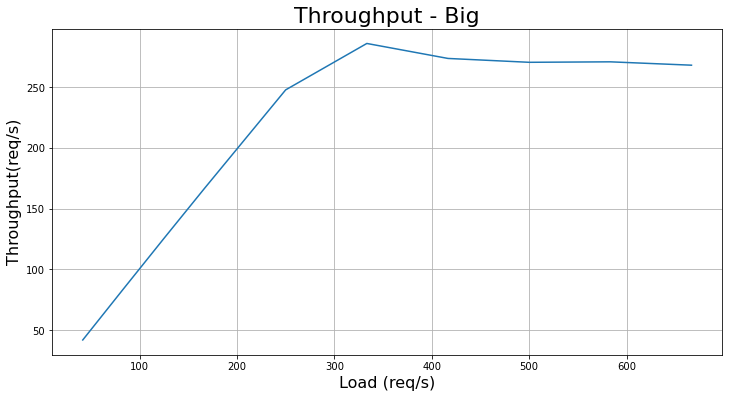

In [4]:
plt.figure(figsize = (12, 6))
plt.plot(df_big_mean['dim']/60, df_big_mean['throughput']);
plt.title('Throughput - Big', size=22)
plt.xlabel('Load (req/s)', size=16)
plt.ylabel('Throughput(req/s)', size=16)
plt.grid()
plt.show()

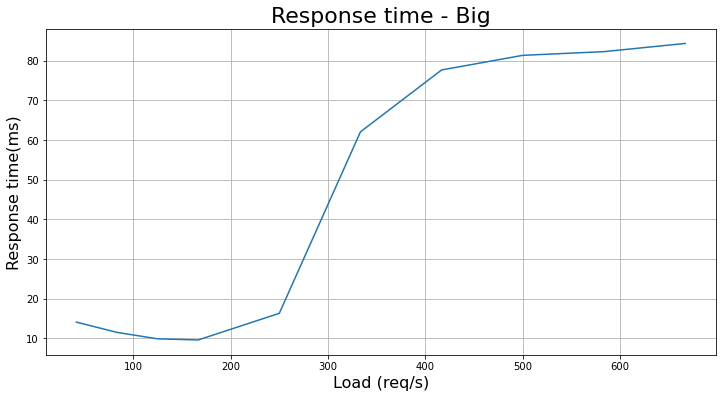

In [5]:
plt.figure(figsize = (12, 6))
plt.plot(df_big_mean['dim']/60, df_big_mean['resp_time']);
plt.title('Response time - Big', size=22)
plt.xlabel('Load (req/s)', size=16)
plt.ylabel('Response time(ms)', size=16)
plt.grid()
plt.show()

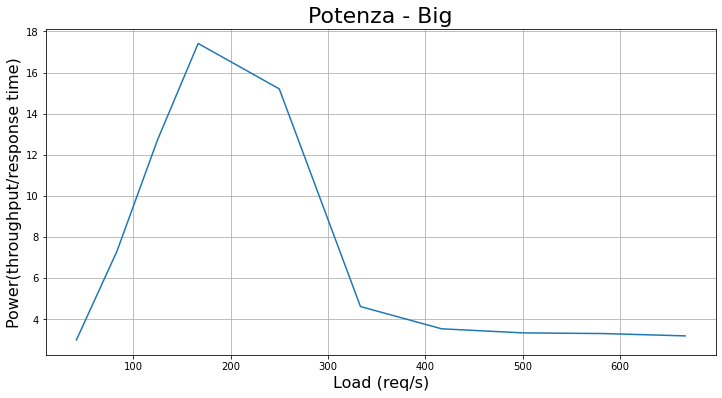

In [6]:
plt.figure(figsize = (12, 6))
plt.plot(df_big_mean['dim']/60, df_big_mean['throughput']/df_big_mean['resp_time']);
plt.title('Potenza - Big', size=22)
plt.xlabel('Load (req/s)', size=16)
plt.ylabel('Power(throughput/response time)', size=16)
plt.grid()
plt.show()

In [7]:
dim=list(df_big_mean['dim']/60)
thr=list(df_big_mean['throughput'])
pot=list(df_big_mean['throughput']/df_big_mean['resp_time'])
ymax = max(thr)
xpos = thr.index(ymax)
u_c_big = dim[xpos]
print('Il valore di usable capacity è', u_c_big, 'ed ha come throughput', ymax)
ymax2 = max(pot)
xpos2 = pot.index(ymax2)
k_c_big = dim[xpos2]
print('Il valore di knee capacity è', k_c_big, 'ed ha come potenza', ymax2)

Il valore di usable capacity è 333.3333333333333 ed ha come throughput 285.8233333333334
Il valore di knee capacity è 166.66666666666666 ed ha come potenza 17.416260212046264


# New Small 5 iter

In [8]:
df_small = pd.DataFrame(columns=['dim', 'resp_time', 'throughput'])

for root, dirs, files in os.walk(path_small):
    for file in files:
        if file.endswith("0.csv"):
            dim=int(file.strip(".csv"))
            df = pd.read_csv(os.path.join(root, file))
            tp = df[df.responseMessage == 'OK'].shape[0]/60
            resp_time = df.elapsed
            resp_time.replace(0, np.nan, inplace=True)
            resp_time = resp_time.mean(skipna=True)
            row=[int(dim), resp_time, tp]
            df_small.loc[len(df_small)] = row

df_small.sort_values(by='dim',inplace=True, ignore_index=True)

df_small

,dim,resp_time,throughput
0,10000.0,2.297138,167.150000
1,10000.0,11.042980,167.133333
2,10000.0,3.124289,167.083333
3,10000.0,2.271014,167.150000
4,10000.0,2.256758,167.083333
5,20000.0,7.183822,328.216667
6,20000.0,4.505070,332.000000
7,20000.0,2.591054,333.500000
8,20000.0,2.374788,333.700000
9,20000.0,2.629820,324.616667


In [9]:
dim = []
tr = []
resp = []

for k,i in df_small.groupby('dim'):
    t_std = df_small.groupby('dim').get_group(k)['throughput'].std()
    r_std = df_small.groupby('dim').get_group(k)['resp_time'].std()
    t_mean = df_small.groupby('dim').get_group(k)['throughput'].mean()
    r_mean = df_small.groupby('dim').get_group(k)['resp_time'].mean()
    t_med = df_small.groupby('dim').get_group(k)['throughput'].median()
    r_med = df_small.groupby('dim').get_group(k)['resp_time'].median()
    
    t_cov = t_std/t_mean
    r_cov = r_std/r_mean
    dim.append(k)
    if t_cov < 0.5:
        tr.append(t_mean)
    else:
        tr.append(t_med)
    if r_cov < 0.5:
        resp.append(r_mean)
    else:
        resp.append(r_med)
    
df_small_mean = pd.DataFrame({'dim':dim, 'throughput':tr, 'resp_time':resp})
df_small_mean

,dim,throughput,resp_time
0,10000.0,167.120000,2.297138
1,20000.0,330.406667,2.629820
2,30000.0,494.060000,3.183110
3,40000.0,645.033333,3.903701
4,60000.0,802.120000,5.407569
5,80000.0,963.680000,22.525874
6,100000.0,955.506667,23.848461
7,125000.0,958.473333,24.078219
8,150000.0,921.656667,24.807784


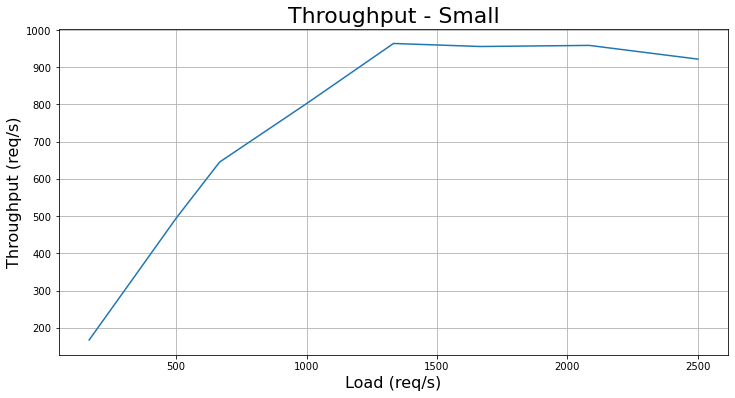

In [10]:
plt.figure(figsize = (12, 6))
plt.plot(df_small_mean['dim']/60, df_small_mean['throughput']);
plt.title('Throughput - Small', size=22)
plt.xlabel('Load (req/s)', size=16)
plt.ylabel('Throughput (req/s)', size=16)
plt.grid()
plt.show()

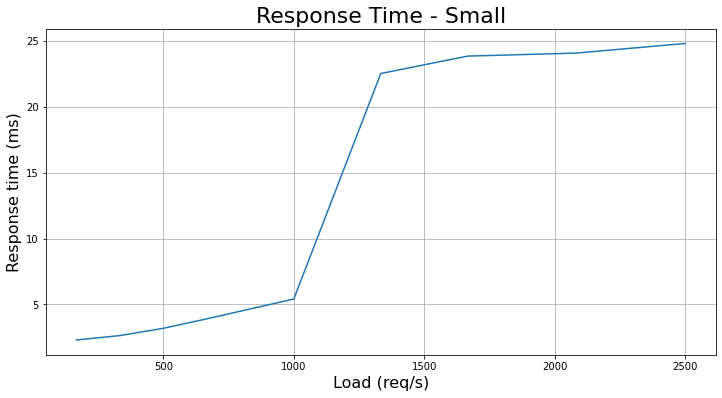

In [11]:
plt.figure(figsize = (12, 6))
plt.plot(df_small_mean['dim']/60, df_small_mean['resp_time']);
plt.title('Response Time - Small', size=22)
plt.xlabel('Load (req/s)', size=16)
plt.ylabel('Response time (ms)', size=16)
plt.grid()
plt.show()

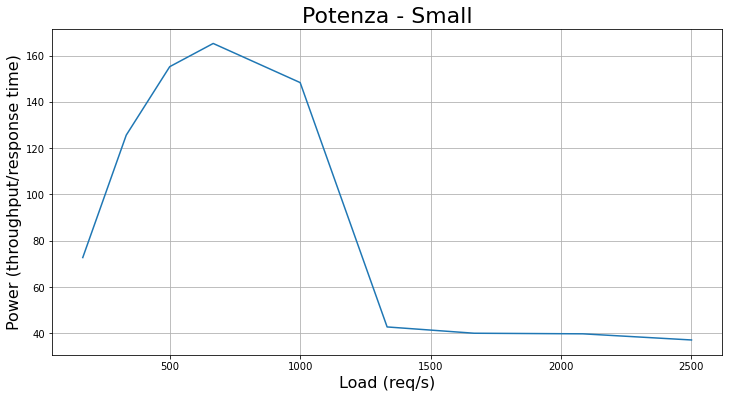

In [12]:
plt.figure(figsize = (12, 6))
plt.plot(df_small_mean['dim']/60, df_small_mean['throughput']/df_small_mean['resp_time']);
plt.title('Potenza - Small', size=22)
plt.xlabel('Load (req/s)', size=16)
plt.ylabel('Power (throughput/response time)', size=16)
plt.grid()
plt.show()

In [13]:
dim=list(df_small_mean['dim']/60)
thr=list(df_small_mean['throughput'])
pot=list(df_small_mean['throughput']/df_small_mean['resp_time'])
ymax = max(thr)
xpos = thr.index(ymax)
u_c_big = dim[xpos]
print('Il valore di usable capacity è', u_c_big, 'ed ha come throughput', ymax)
ymax2 = max(pot)
xpos2 = pot.index(ymax2)
k_c_big = dim[xpos2]
print('Il valore di knee capacity è', k_c_big, 'ed ha come potenza', ymax2)

Il valore di usable capacity è 1333.3333333333333 ed ha come throughput 963.6800000000001
Il valore di knee capacity è 666.6666666666666 ed ha come potenza 165.23633886387546


# Random

In [14]:
df_random = pd.DataFrame(columns=['dim', 'resp_time', 'throughput'])

for root, dirs, files in os.walk(path_random):
    for file in files:
        if file.endswith("0.csv"):
            dim=int(file.strip(".csv"))
            df = pd.read_csv(os.path.join(root, file))
            tp = df[df.responseMessage == 'OK'].shape[0]/60
            resp_time = df.elapsed
            resp_time.replace(0, np.nan, inplace=True)
            resp_time = resp_time.mean(skipna=True)
            row=[int(dim), resp_time, tp]
            df_random.loc[len(df_random)] = row

df_random.sort_values(by='dim',inplace=True, ignore_index=True)

df_random

,dim,resp_time,throughput
0,2500.0,26.672339,42.116667
1,2500.0,25.631809,41.916667
2,2500.0,27.384250,42.116667
3,2500.0,30.875346,42.116667
4,2500.0,10.269276,42.150000
5,5000.0,37.681529,81.116667
6,5000.0,29.567854,83.266667
7,5000.0,30.063050,83.266667
8,5000.0,35.396279,83.316667
9,5000.0,16.422311,83.666667


In [15]:
dim = []
tr = []
resp = []

for k,i in df_random.groupby('dim'):
    t_std = df_random.groupby('dim').get_group(k)['throughput'].std()
    r_std = df_random.groupby('dim').get_group(k)['resp_time'].std()
    t_mean = df_random.groupby('dim').get_group(k)['throughput'].mean()
    r_mean = df_random.groupby('dim').get_group(k)['resp_time'].mean()
    t_med = df_random.groupby('dim').get_group(k)['throughput'].median()
    r_med = df_random.groupby('dim').get_group(k)['resp_time'].median()
    
    t_cov = t_std/t_mean
    r_cov = r_std/r_mean
    dim.append(k)
    if t_cov < 0.5:
        tr.append(t_mean)
    else:
        tr.append(t_med)
    if r_cov < 0.5:
        resp.append(r_mean)
    else:
        resp.append(r_med)
    
df_random_mean = pd.DataFrame({'dim':dim, 'throughput':tr, 'resp_time':resp})
df_random_mean

,dim,throughput,resp_time
0,2500.0,42.083333,24.166604
1,5000.0,82.926667,29.826205
2,7500.0,122.556667,37.615100
3,10000.0,159.070000,43.976158
4,15000.0,197.576667,88.946241
5,20000.0,158.663333,132.116745
6,25000.0,149.253333,153.556372
7,30000.0,149.133333,156.100901
8,35000.0,146.970000,160.057140
9,40000.0,134.740000,177.360314


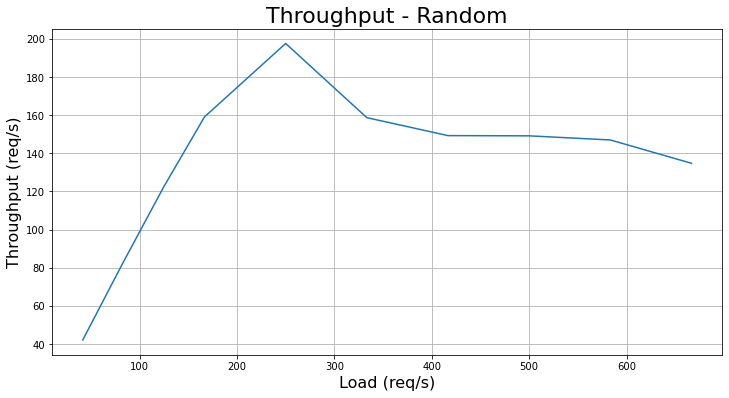

In [16]:
plt.figure(figsize = (12, 6))
plt.plot(df_random_mean['dim']/60, df_random_mean['throughput']);
plt.title('Throughput - Random', size=22)
plt.xlabel('Load (req/s)', size=16)
plt.ylabel('Throughput (req/s)', size=16)
plt.grid()
plt.show()

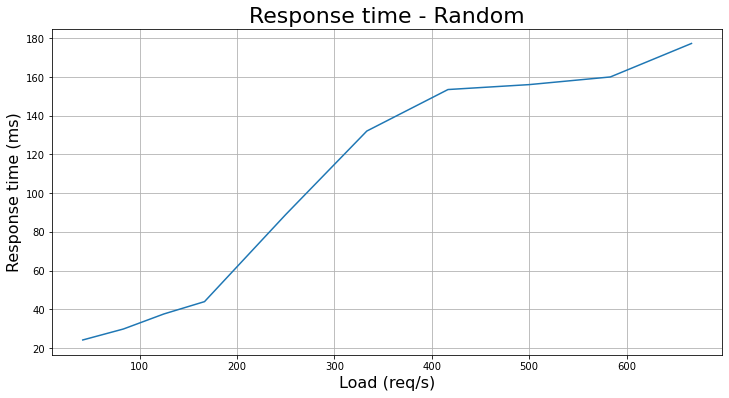

In [17]:
plt.figure(figsize = (12, 6))
plt.plot(df_random_mean['dim']/60, df_random_mean['resp_time']);
plt.title('Response time - Random', size=22)
plt.xlabel('Load (req/s)', size=16)
plt.ylabel('Response time (ms)', size=16)
plt.grid()
plt.show()

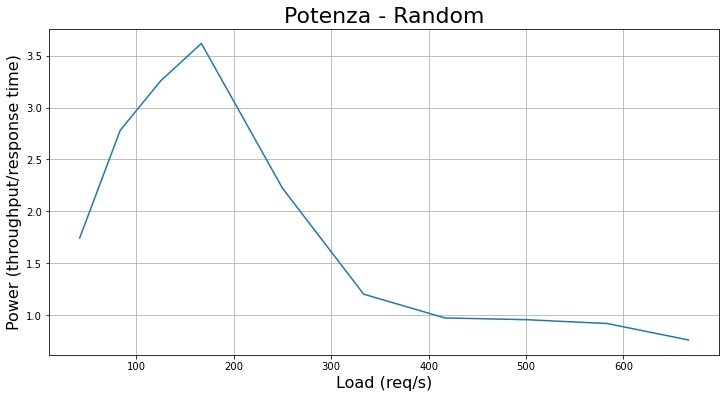

In [18]:
plt.figure(figsize = (12, 6))
plt.plot(df_random_mean['dim']/60, df_random_mean['throughput']/df_random_mean['resp_time']);
plt.title('Potenza - Random', size=22)
plt.xlabel('Load (req/s)', size=16)
plt.ylabel('Power (throughput/response time)', size=16)
plt.grid()
plt.show()

In [19]:
dim=list(df_random_mean['dim']/60)
thr=list(df_random_mean['throughput'])
pot=list(df_random_mean['throughput']/df_random_mean['resp_time'])
ymax = max(thr)
xpos = thr.index(ymax)
u_c_big = dim[xpos]
print('Il valore di usable capacity è', u_c_big, 'ed ha come throughput', ymax)
ymax2 = max(pot)
xpos2 = pot.index(ymax2)
k_c_big = dim[xpos2]
print('Il valore di knee capacity è', k_c_big, 'ed ha come potenza', ymax2)

Il valore di usable capacity è 250.0 ed ha come throughput 197.57666666666665
Il valore di knee capacity è 166.66666666666666 ed ha come potenza 3.6171873137911486
